# Triathlon Recommender System by Todd Dole

Triathlon Recommender System
By Todd Dole

Project description:
I am creating a recommender system to recommend races to triathletes.
This recommender system will be based on publicly available data from 1983-2022, available on Kaggle here:
https://www.kaggle.com/datasets/vladislavboyadzhi/triathlon-results

A few words on the data.  This data contains race results on over 2000 courses, with a million individual participation records.  It purports to contain all publicly
available race data from 1983-2022.  However, for myself personally, it only includes three races during that period, when I completed at least 20 (and I know many of those
have results available online).  So the data is not nearly as complete as we might hope for a project like this.  Nonetheless, we will see if we can use it to build a 
decent race recommender system.

We will approach this with two different styles of recommendations.
1. Athlete clustering based on similar events.  The system will recommend races based on what courses athletes with similar profiles have raced.
2. Athlete clustering based on relative performance.  The idea here is that this will recommend courses that are well suited to a particular
   athlete based on performances of similar athletes.  In Triathlon, athletes generally compete against other athletes within the same gender and 
   five year age range (e.g. M30-34).  Each athlete will be given a percentile score for how they did compared to their age group for each race. 
   This score will then be used as a rating system, so that the system recommends courses where similar athletes have performed well relative
   to their competition over courses where similar athletes have performed poorly.  In theory this should result in course recommendations where
   athletes are well suited to the particular course and are potentially able to maximize their standing relative to the competition.

A few caveats.  First, figuring out which races no longer exist and which races are still available is beyond the scope of this exercise.  
   This recommender system may recommend races that haven't been run since the 1990's.
Second, given the nature of the class and the methods used, we will make no effort to indicate WHY a given course is recommended.  Some athletes 
   will perform relatively well on hilly courses, while others will perform better on flat courses.  Some athletes outperform their peers when a 
   race occurs at hotter temperatures, and some perform better in the cold.  While the reasons would be helpful, this will be beyond the scope
   of this system.

In [1]:
!pip install --upgrade pandas numpy matplotlib seaborn scikit-learn nltk scipy scikit-surprise

  Using cached numpy-2.0.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)


In [2]:
import os; os.environ['OPENBLAS_NUM_THREADS']='1'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import implicit
from sklearn.model_selection import train_test_split
import threadpoolctl
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import GridSearchCV

# First steps

We will begin by loading the data.

The data exists in two files.  The first contains information about each event, and the second contains results.

In [3]:
events_df = pd.read_csv('data/postgres_public_tristat_events.csv')
stats_df = pd.read_csv('data/postgres_public_tristat_stat.csv')

# EDA

Let's begin with some EDA...

In [4]:
events_df.head()

,event_dt,event_flg,event_name,event_f_cnt,event_m_cnt,event_link
0,2022-12-11,USA,Ironman Florida 70.3 2022,383,1105,/rus/result/ironman/florida/half/2022
1,2022-12-10,NZL,Ironman New Zealand 2022,93,318,/rus/result/ironman/new-zealand/full/2022
2,2022-12-10,NZL,Ironman New Zealand 70.3 2022,275,532,/rus/result/ironman/new-zealand/half/2022
3,2022-12-09,BRN,Ironman Bahrain 70.3 2022,107,576,/rus/result/ironman/bahrain/half/2022
4,2022-12-04,ARG,Ironman Argentina 2022,21,290,/rus/result/ironman/argentina/full/2022


In [5]:
stats_df.head()

,event_link,gender,person_link,person_flag,person_name,person_event_group,person_event_swim_time_text,person_event_t1_time_text,person_event_cycle_time_text,person_event_t2_time_text,person_event_run_time_text,person_event_finish_time_text
0,/rus/result/ironman/ireland-cork/full/2019,M,/irl/profile/halliwell-mark,IRL,"Halliwell, Mark",M45-49,0:00,0:00,7:52:05,19:00,5:26:34,13:37:39
1,/rus/result/ironman/ireland-cork/full/2019,F,/usa/profile/harris-polly,USA,"Harris, Polly",F50-54,0:00,0:00,7:58:53,16:37,5:22:09,13:37:40
2,/rus/result/ironman/ireland-cork/full/2019,M,/fra/profile/peugeot-rodolphe,FRA,"Peugeot, Rodolphe",M25-29,0:00,0:00,7:57:05,10:40,5:30:10,13:37:55
3,/rus/result/ironman/ireland-cork/full/2019,F,/gbr/profile/crawford-lisa,GBR,"Crawford, Lisa",F50-54,0:00,0:00,7:44:47,12:51,5:40:21,13:37:59
4,/rus/result/ironman/ireland-cork/full/2019,M,/usa/profile/brumit-aaron,USA,"Brumit, Aaron",M45-49,0:00,0:00,7:12:38,34:01,5:51:50,13:38:29


# Standardizing names

Looking through the data, there are variations of the same name with different capitalizations.  Let's fix that.


In [6]:
# Function to standardize athlete names
def standardize_name(name):
    if pd.isna(name):
        return name
    return name.strip().lower().title()

# Apply the function to standardize the person_name column
stats_df['person_name'] = stats_df['person_name'].apply(standardize_name)

# Missing Values

Next, we will check for any missing values, and adjust the data accordingly.

In [7]:
# Check for missing values
missing_values = stats_df.isnull().sum()
# Display the missing values
print("\nMissing Values:")
print(missing_values)


Missing Values:
event_link                           0
gender                               5
person_link                      66742
person_flag                      59038
person_name                          1
person_event_group                1547
person_event_swim_time_text          0
person_event_t1_time_text            0
person_event_cycle_time_text         0
person_event_t2_time_text            0
person_event_run_time_text           0
person_event_finish_time_text        0
dtype: int64


The person_event_group column contains the name of the division in which the athlete is competing.  Data that is missing that is not going to be
helpful to us for the purpose of this exercise, so we will remove those entries.  Likewise, we will get rid of the one row which is missing an athlete name.

In [8]:
# Remove rows with missing person_name or person_event_group
stats_df = stats_df.dropna(subset=['person_name', 'person_event_group'])

# Generate person id numbers

We need to generate a unique id number for each person.  For most of the records, there is a person_link entry that is unique to each person.
In a few cases, the person_link is not present and we will use the person_name instead.  This may result in people with the same name being 
lumped together, but the data does not give us an easy way to avoid this.  We will double check the data later to see if there are any
egregious examples of this.

In [9]:
# Generate unique person IDs based on person_link
person_id_map = {link: idx for idx, link in enumerate(stats_df['person_link'].unique())}
# Generate unique person IDs based on person_link, and use person_name if person_link is missing
def generate_person_id(row):
    if pd.notna(row['person_link']):
        return row['person_link']
    return row['person_name']

stats_df['person_identifier'] = stats_df.apply(generate_person_id, axis=1)
person_id_map = {identifier: idx for idx, identifier in enumerate(stats_df['person_identifier'].unique())}
stats_df['person_id'] = stats_df['person_identifier'].map(person_id_map)

In [10]:
stats_df.head()

,event_link,gender,person_link,person_flag,person_name,person_event_group,person_event_swim_time_text,person_event_t1_time_text,person_event_cycle_time_text,person_event_t2_time_text,person_event_run_time_text,person_event_finish_time_text,person_identifier,person_id
0,/rus/result/ironman/ireland-cork/full/2019,M,/irl/profile/halliwell-mark,IRL,"Halliwell, Mark",M45-49,0:00,0:00,7:52:05,19:00,5:26:34,13:37:39,/irl/profile/halliwell-mark,0
1,/rus/result/ironman/ireland-cork/full/2019,F,/usa/profile/harris-polly,USA,"Harris, Polly",F50-54,0:00,0:00,7:58:53,16:37,5:22:09,13:37:40,/usa/profile/harris-polly,1
2,/rus/result/ironman/ireland-cork/full/2019,M,/fra/profile/peugeot-rodolphe,FRA,"Peugeot, Rodolphe",M25-29,0:00,0:00,7:57:05,10:40,5:30:10,13:37:55,/fra/profile/peugeot-rodolphe,2
3,/rus/result/ironman/ireland-cork/full/2019,F,/gbr/profile/crawford-lisa,GBR,"Crawford, Lisa",F50-54,0:00,0:00,7:44:47,12:51,5:40:21,13:37:59,/gbr/profile/crawford-lisa,3
4,/rus/result/ironman/ireland-cork/full/2019,M,/usa/profile/brumit-aaron,USA,"Brumit, Aaron",M45-49,0:00,0:00,7:12:38,34:01,5:51:50,13:38:29,/usa/profile/brumit-aaron,4


# Generate Course ID numbers

We will also generate a unique id number for each race course.  Note that it is beyond the scope of this project to separate out races where the course changes from year to year.  For example, all years of Ironman Florida will be given the same course id, despite the fact that the course
 changed significantly several times over the years.

In [11]:
# Generate unique course IDs
def extract_course_identifier(event_link):
    parts = event_link.split('/')
    if len(parts) > 5:
        return '/'.join(parts[3:6])
    return event_link

events_df['course_identifier'] = events_df['event_link'].apply(extract_course_identifier)
course_id_map = {identifier: idx for idx, identifier in enumerate(events_df['course_identifier'].unique())}
events_df['course_id'] = events_df['course_identifier'].map(course_id_map)


In [12]:
events_df.head()

,event_dt,event_flg,event_name,event_f_cnt,event_m_cnt,event_link,course_identifier,course_id
0,2022-12-11,USA,Ironman Florida 70.3 2022,383,1105,/rus/result/ironman/florida/half/2022,ironman/florida/half,0
1,2022-12-10,NZL,Ironman New Zealand 2022,93,318,/rus/result/ironman/new-zealand/full/2022,ironman/new-zealand/full,1
2,2022-12-10,NZL,Ironman New Zealand 70.3 2022,275,532,/rus/result/ironman/new-zealand/half/2022,ironman/new-zealand/half,2
3,2022-12-09,BRN,Ironman Bahrain 70.3 2022,107,576,/rus/result/ironman/bahrain/half/2022,ironman/bahrain/half,3
4,2022-12-04,ARG,Ironman Argentina 2022,21,290,/rus/result/ironman/argentina/full/2022,ironman/argentina/full,4


# Merge the data together

In [13]:
# Merge the datasets on the event_link
merged_df = pd.merge(stats_df, events_df, left_on='event_link', right_on='event_link', suffixes=('_stats', '_events'))

# Let's add an event type column

# Function to extract event type from course identifier
def extract_event_type(course_identifier):
    if 'full' in course_identifier.lower():
        return 'full'
    elif 'half' in course_identifier.lower():
        return 'half'
    elif 'olympic' in course_identifier.lower():
        return 'olympic'
    elif 'sprint' in course_identifier.lower():
        return 'sprint'
    else:
        return 'other'

# Apply the function to create a new column for event type
merged_df['event_type'] = merged_df['course_identifier'].apply(extract_event_type)


merged_df.head()

,event_link,gender,person_link,person_flag,person_name,person_event_group,person_event_swim_time_text,person_event_t1_time_text,person_event_cycle_time_text,person_event_t2_time_text,...,person_identifier,person_id,event_dt,event_flg,event_name,event_f_cnt,event_m_cnt,course_identifier,course_id,event_type
0,/rus/result/ironman/ireland-cork/full/2019,M,/irl/profile/halliwell-mark,IRL,"Halliwell, Mark",M45-49,0:00,0:00,7:52:05,19:00,...,/irl/profile/halliwell-mark,0,2019-06-23,IRL,Ironman Ireland Cork 2019,202,1205,ironman/ireland-cork/full,116,full
1,/rus/result/ironman/ireland-cork/full/2019,F,/usa/profile/harris-polly,USA,"Harris, Polly",F50-54,0:00,0:00,7:58:53,16:37,...,/usa/profile/harris-polly,1,2019-06-23,IRL,Ironman Ireland Cork 2019,202,1205,ironman/ireland-cork/full,116,full
2,/rus/result/ironman/ireland-cork/full/2019,M,/fra/profile/peugeot-rodolphe,FRA,"Peugeot, Rodolphe",M25-29,0:00,0:00,7:57:05,10:40,...,/fra/profile/peugeot-rodolphe,2,2019-06-23,IRL,Ironman Ireland Cork 2019,202,1205,ironman/ireland-cork/full,116,full
3,/rus/result/ironman/ireland-cork/full/2019,F,/gbr/profile/crawford-lisa,GBR,"Crawford, Lisa",F50-54,0:00,0:00,7:44:47,12:51,...,/gbr/profile/crawford-lisa,3,2019-06-23,IRL,Ironman Ireland Cork 2019,202,1205,ironman/ireland-cork/full,116,full
4,/rus/result/ironman/ireland-cork/full/2019,M,/usa/profile/brumit-aaron,USA,"Brumit, Aaron",M45-49,0:00,0:00,7:12:38,34:01,...,/usa/profile/brumit-aaron,4,2019-06-23,IRL,Ironman Ireland Cork 2019,202,1205,ironman/ireland-cork/full,116,full


# Convert Times to Common Format

For our purposes, we will need to convert all the times to a common format.  We will use seconds.

In [14]:
# Convert time fields to a common format (e.g., seconds)
def convert_time_to_seconds(time_str):
    if time_str == "0:00" or time_str == "DNF":
        return 0
    parts = time_str.split(':')
    if len(parts) == 3:
        return int(parts[0]) * 3600 + int(parts[1]) * 60 + int(parts[2])
    elif len(parts) == 2:
        return int(parts[0]) * 60 + int(parts[1])
    return 0

time_columns = ['person_event_swim_time_text', 'person_event_t1_time_text', 'person_event_cycle_time_text', 
                'person_event_t2_time_text', 'person_event_run_time_text', 'person_event_finish_time_text']

for col in time_columns:
    merged_df[col] = merged_df[col].apply(convert_time_to_seconds)
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

In [15]:
merged_df.head()

,event_link,gender,person_link,person_flag,person_name,person_event_group,person_event_swim_time_text,person_event_t1_time_text,person_event_cycle_time_text,person_event_t2_time_text,...,person_identifier,person_id,event_dt,event_flg,event_name,event_f_cnt,event_m_cnt,course_identifier,course_id,event_type
0,/rus/result/ironman/ireland-cork/full/2019,M,/irl/profile/halliwell-mark,IRL,"Halliwell, Mark",M45-49,0,0,28325,1140,...,/irl/profile/halliwell-mark,0,2019-06-23,IRL,Ironman Ireland Cork 2019,202,1205,ironman/ireland-cork/full,116,full
1,/rus/result/ironman/ireland-cork/full/2019,F,/usa/profile/harris-polly,USA,"Harris, Polly",F50-54,0,0,28733,997,...,/usa/profile/harris-polly,1,2019-06-23,IRL,Ironman Ireland Cork 2019,202,1205,ironman/ireland-cork/full,116,full
2,/rus/result/ironman/ireland-cork/full/2019,M,/fra/profile/peugeot-rodolphe,FRA,"Peugeot, Rodolphe",M25-29,0,0,28625,640,...,/fra/profile/peugeot-rodolphe,2,2019-06-23,IRL,Ironman Ireland Cork 2019,202,1205,ironman/ireland-cork/full,116,full
3,/rus/result/ironman/ireland-cork/full/2019,F,/gbr/profile/crawford-lisa,GBR,"Crawford, Lisa",F50-54,0,0,27887,771,...,/gbr/profile/crawford-lisa,3,2019-06-23,IRL,Ironman Ireland Cork 2019,202,1205,ironman/ireland-cork/full,116,full
4,/rus/result/ironman/ireland-cork/full/2019,M,/usa/profile/brumit-aaron,USA,"Brumit, Aaron",M45-49,0,0,25958,2041,...,/usa/profile/brumit-aaron,4,2019-06-23,IRL,Ironman Ireland Cork 2019,202,1205,ironman/ireland-cork/full,116,full


# Check for Missing Values

In [16]:
# Check for missing values
missing_values = merged_df.isnull().sum()
# Display the missing values
print("\nMissing Values:")
print(missing_values)


Missing Values:
event_link                           0
gender                               5
person_link                      66370
person_flag                      58669
person_name                          0
person_event_group                   0
person_event_swim_time_text          0
person_event_t1_time_text            0
person_event_cycle_time_text         0
person_event_t2_time_text            0
person_event_run_time_text           0
person_event_finish_time_text        0
person_identifier                    0
person_id                            0
event_dt                             0
event_flg                            0
event_name                           0
event_f_cnt                          0
event_m_cnt                          0
course_identifier                    0
course_id                            0
event_type                           0
dtype: int64


In [17]:
# Basic information
total_events = merged_df['event_link'].nunique()
total_athletes = merged_df['person_id'].nunique()
average_athletes_per_event = merged_df.groupby('event_link')['person_id'].nunique().mean()
average_events_per_course = merged_df.groupby('course_id')['event_link'].nunique().mean()

# Create a summary table
summary_table = pd.DataFrame({
    'Total Events': [total_events],
    'Total Athletes': [total_athletes],
    'Average Athletes per Event': [average_athletes_per_event],
    'Average Events per Course': [average_events_per_course]
})

In [18]:
# Display the summary table
print("Summary Table:")
print(summary_table)

Summary Table:
   Total Events  Total Athletes  Average Athletes per Event  \
0          6012         1079571                  490.438456   

   Average Events per Course  
0                   2.703237  


# Outliers
Let's look for outliers in our finish times and eliminate them

In [19]:
# Define the minimum finish times for each event type in seconds
# These are somewhat arbitrary since occasionally a race will be modified by weather and result in unusually short times. 
# But this should filter out any times that are impossibly low.
min_finish_times = {
    'full': 7 * 3600,      # 7 hours
    'half': 3 * 3600,      # 3 hours
    'olympic': 1 * 3600,   # 1 hour
    'sprint': 20 * 60      # 20 minutes
}
# Function to identify outliers based on finish time and event type
def identify_outliers(df):
    event_type = df['event_type'].iloc[0]
    if event_type in min_finish_times:
        return df[df['person_event_finish_time_text'] < min_finish_times[event_type]]
    return pd.DataFrame()

# Apply the function to identify outliers
outliers_df = merged_df.groupby('event_type', group_keys=False).apply(lambda x: identify_outliers(x)).reset_index(drop=True)

# Display the number of outliers for each event type
outlier_counts = outliers_df['event_type'].value_counts()
print("Number of outliers by event type:")
print(outlier_counts)


Number of outliers by event type:
event_type
full       3595
half       3282
olympic    2758
sprint     1292
Name: count, dtype: int64


/tmp/ipykernel_4550/2297024620.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_df = merged_df.groupby('event_type', group_keys=False).apply(lambda x: identify_outliers(x)).reset_index(drop=True)


In [20]:
# Function to filter out outliers based on finish time and event type
def filter_outliers(df):
    event_type = df['event_type'].iloc[0]
    if event_type in min_finish_times:
        return df[df['person_event_finish_time_text'] >= min_finish_times[event_type]]
    return df

# Apply the function to filter out outliers
merged_df = merged_df.groupby('event_type').apply(filter_outliers).reset_index(drop=True)


/tmp/ipykernel_4550/2308850713.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df = merged_df.groupby('event_type').apply(filter_outliers).reset_index(drop=True)


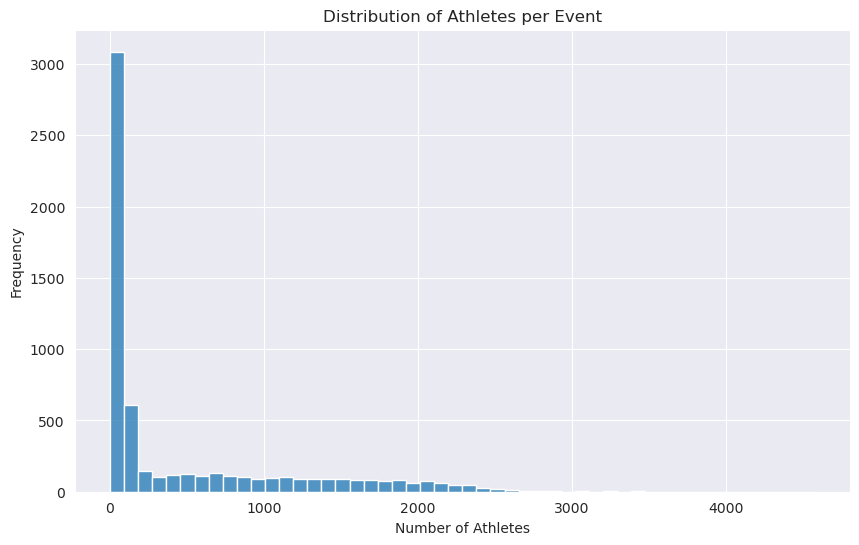

In [21]:

# Distribution of athletes per event
plt.figure(figsize=(10, 6))
sns.histplot(merged_df.groupby('event_link')['person_id'].nunique(), bins=50)
plt.title('Distribution of Athletes per Event')
plt.xlabel('Number of Athletes')
plt.ylabel('Frequency')
plt.show()



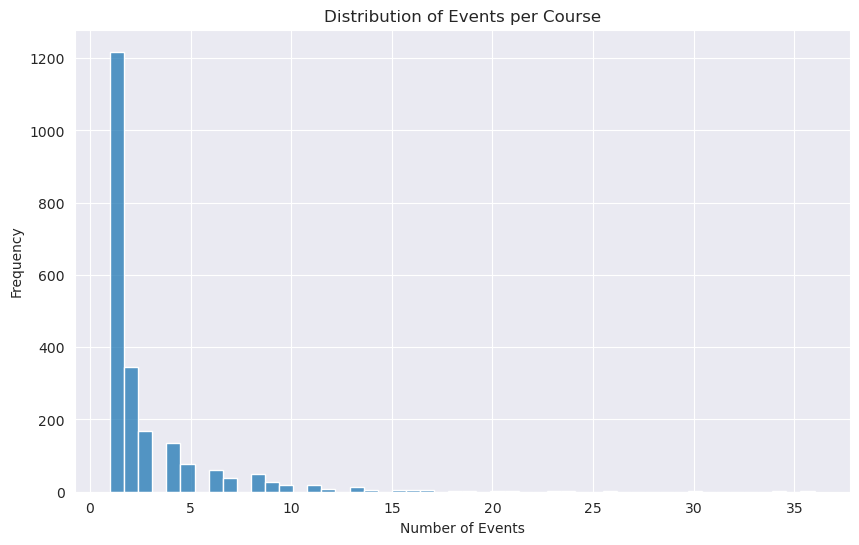

In [22]:
# Distribution of events per course
plt.figure(figsize=(10, 6))
sns.histplot(merged_df.groupby('course_id')['event_link'].nunique(), bins=50)
plt.title('Distribution of Events per Course')
plt.xlabel('Number of Events')
plt.ylabel('Frequency')
plt.show()



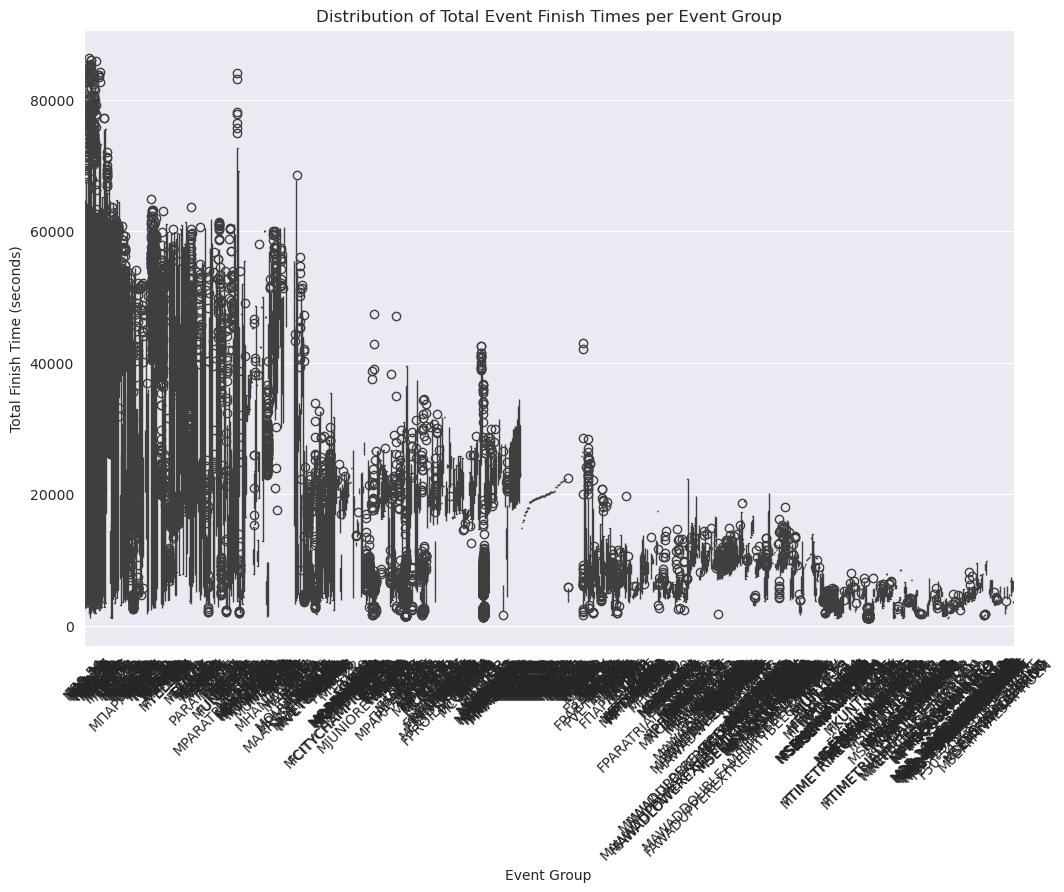

In [23]:
# Distribution of total event finish times per event group
plt.figure(figsize=(12, 8))
sns.boxplot(x='person_event_group', y='person_event_finish_time_text', data=merged_df)
plt.title('Distribution of Total Event Finish Times per Event Group')
plt.xlabel('Event Group')
plt.ylabel('Total Finish Time (seconds)')
plt.xticks(rotation=45)
plt.show()

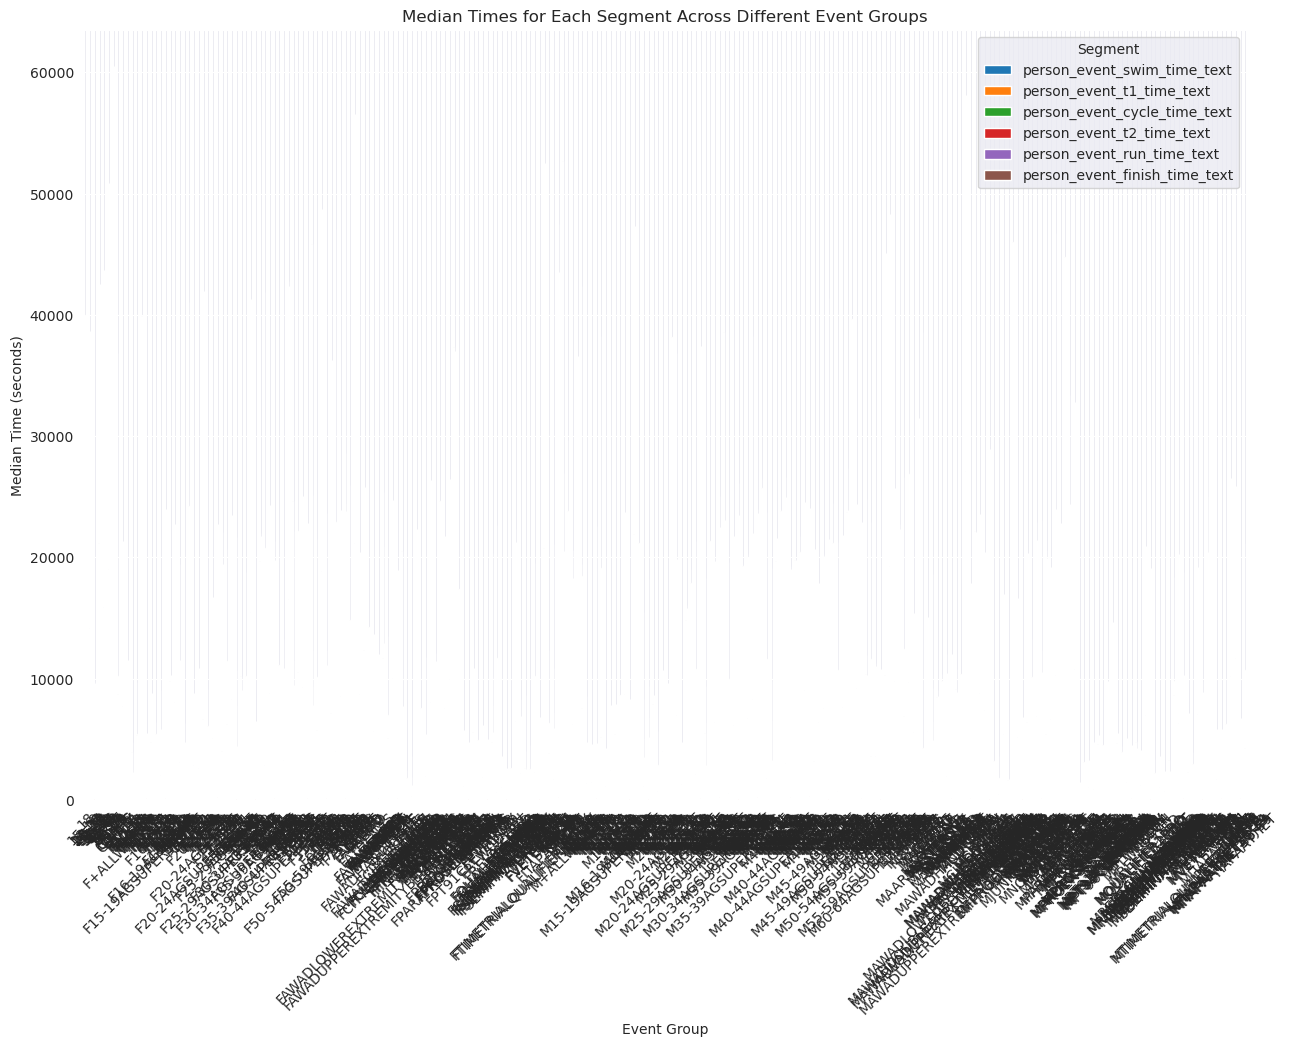

In [24]:
# Median times for each segment across different event groups
median_times = merged_df.groupby('person_event_group')[time_columns].median()

# Plot median times
median_times.plot(kind='bar', figsize=(15, 10))
plt.title('Median Times for Each Segment Across Different Event Groups')
plt.xlabel('Event Group')
plt.ylabel('Median Time (seconds)')
plt.legend(title='Segment')
plt.xticks(rotation=45)
plt.show()

In [25]:
# List unique person_event_group values
unique_event_groups = merged_df['person_event_group'].unique()

print(unique_event_groups)

['M45-49' 'F50-54' 'M25-29' 'F40-44' 'M50-54' 'M40-44' 'F35-39' 'M35-39'
 'M18-24' 'M55-59' 'M30-34' 'F30-34' 'F25-29' 'F18-24' 'M65-69' 'M60-64'
 'F45-49' 'F55-59' 'F60-64' 'M75-79' 'M' 'F' 'MBLUE' 'MWHITE' 'FWHITE'
 'FBLUE' 'MPRO' 'FPRO' 'M70-74' 'F65-69' 'MPC' 'F70-74' 'FPC' 'M80-84'
 'MXTRI' 'FXTRI' 'M20-24' 'M85-89' 'M18-29' 'F18-29' 'M60-69' 'MПАРААТЛЕТ'
 'M30-35' 'M40-45' 'M35-40' 'M25-30' 'M45-50' 'M50-55' 'M18-19' 'M55-60'
 'M65-70' 'F30-35' 'F55-60' 'M60-65' 'F25-30' 'F40-45' 'F50-55' 'F35-40'
 'F45-50' 'F65-70' 'F60-65' 'M70-75' 'M24-29' 'F24-29' 'M-' 'M-U23'
 'M18-39' 'M50-59' 'M40-49' 'F40-49' 'F18-39' 'M60+' 'K30-34' 'K35-39'
 'K40-44' 'K45-49' 'M16-29' 'M30-39' 'F30-39' 'M70-99' 'F16-29' 'MYELLOW'
 'FYELLOW' 'MTOP3' 'M50' 'M40' 'M25' 'M30' 'M35' 'M55' 'FTOP3' 'M45' 'F25'
 'M20' 'F40' 'F35' 'F45' 'M60' 'F20' 'F55' 'F50' 'M65' 'MBLACK' 'FBLACK'
 'F20-24' 'F50-59' 'F60+' 'F30' 'M70' 'M18' 'M60-99' 'K18-29' 'K30-39'
 'K40-49' 'M25-39' 'F25-39' 'MRELAY' 'PARATHLETE' 'F30-44' 

# Commentary
The above data highlights the fact that age groups have changed some over the years, and that the standard way they are recorded today
(e.g. M30-34) has not always existed.  For the sake of this project, this won't really matter, because we aren't tracking anything related to
age groups apart from the individual event.  

person_event_group
M40-44     383781
M35-39     368902
M30-34     309645
M45-49     304853
M50-54     201523
M25-29     183731
F40-44     103596
F35-39     102196
M55-59     100904
F30-34      99511
MPRO        97575
F45-49      81594
F25-29      71299
FPRO        58758
M18-24      56288
F50-54      54425
M60-64      43498
M           29640
F55-59      26535
F18-24      19049
MJUNIOR     17706
M65-69      16211
M40         15754
M35         14523
FJUNIOR     11992
Name: count, dtype: int64


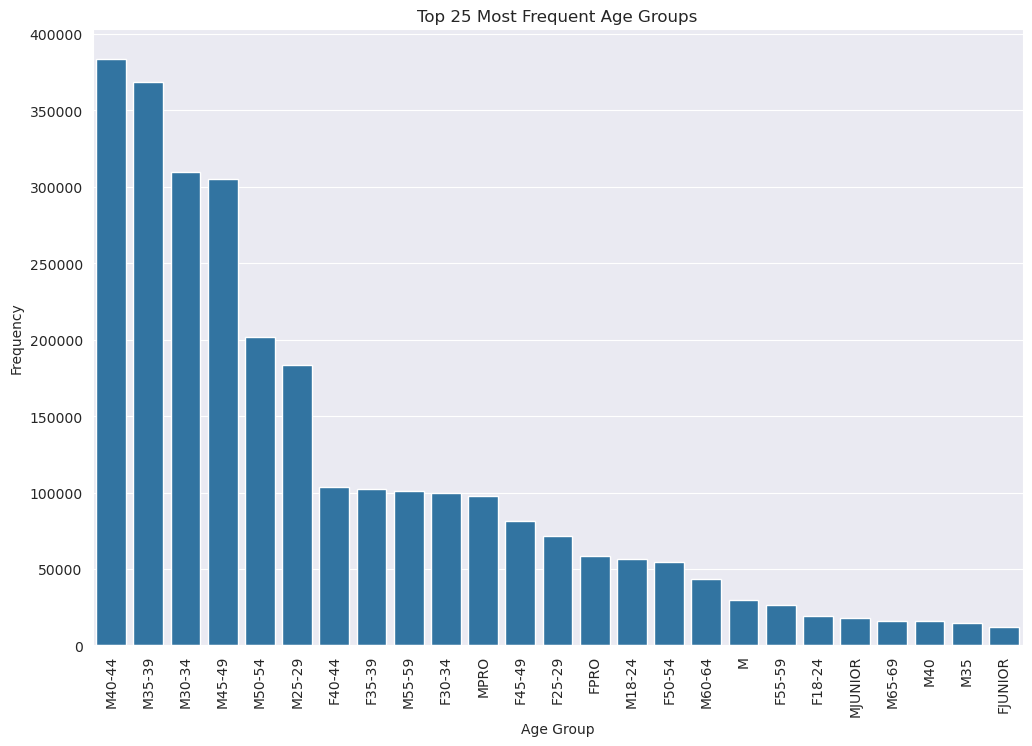

In [26]:
# List unique person_event_group values and their counts
event_group_counts = merged_df['person_event_group'].value_counts()
# Get the top 25 most frequent person_event_group values
top_25_event_groups = event_group_counts.head(25)

print(top_25_event_groups)

# Plot a histogram for the distribution of the top 25 person_event_group values
plt.figure(figsize=(12, 8))
sns.barplot(x=top_25_event_groups.index, y=top_25_event_groups.values)
plt.title('Top 25 Most Frequent Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

# Commentary 
This data is exactly what we would expect to see.  M40-44 and M35-39 have always been the most popular age groups.

Next, we will calculate a percentile score for each race record.  This will scale from 0.0 for the winner to 1.0 for last place.

In [27]:
# Convert the finish time to numeric
merged_df['person_event_finish_time_text'] = pd.to_numeric(merged_df['person_event_finish_time_text'], errors='coerce')

# Function to calculate percentile
def calculate_adjusted_percentile(group):
    group['percentile'] = group['person_event_finish_time_text'].rank(method='max', pct=True, ascending=False)
    return group

# Apply the function to each group
merged_df = merged_df.groupby(['event_link', 'person_event_group']).apply(calculate_adjusted_percentile)

# Save the data with percentile scores for further analysis
#merged_df.to_csv('data/merged_triathlon_data_with_percentiles.csv', index=False)

print("Percentile calculation completed.")

Percentile calculation completed.


/tmp/ipykernel_4550/1099431835.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df = merged_df.groupby(['event_link', 'person_event_group']).apply(calculate_adjusted_percentile)


In [28]:
merged_df.head()

event_link  \
event_link                                         person_event_group                                                              
/rus/result/3grom/bolshoy-moskovskiy-triatlon/h... F18-24             2216043  /rus/result/3grom/bolshoy-moskovskiy-triatlon/...   
                                                   F25-29             2215827  /rus/result/3grom/bolshoy-moskovskiy-triatlon/...   
                                                                      2215858  /rus/result/3grom/bolshoy-moskovskiy-triatlon/...   
                                                                      2215962  /rus/result/3grom/bolshoy-moskovskiy-triatlon/...   
                                                                      2216030  /rus/result/3grom/bolshoy-moskovskiy-triatlon/...   

                                                                              gender  \
event_link                                         person_event_group                  
/rus/result/3grom/bolshoy-moskovskiy-triatlon/h... F18-24             2216043      F   
                                                   F25-29             2215827      F   
                                                                      2215858      F   
                                                                      2215962      F   
                                                                      2216030      F   

                                                                                                    person_link  \
event_link                                         person_event_group                                             
/rus/result/3grom/bolshoy-moskovskiy-triatlon/h... F18-24             2216043    /rus/profile/orlova-anastasiya   
                                                   F25-29             2215827     /rus/profile/koleskina-marina   
                                                                      2215858  /rus/profile/zavyalova-viktoriya   
                                                                      2215962             /rus/profile/dey-rada   
                                                                      2216030       /rus/profile/toporova-alena   

                                                                              person_flag  \
event_link                                         person_event_group                       
/rus/result/3grom/bolshoy-moskovskiy-triatlon/h... F18-24             2216043         RUS   
                                                   F25-29             2215827         RUS   
                                                                      2215858         RUS   
                                                                      2215962         RUS   
                                                                      2216030         RUS   

                                                                                      person_name  \
event_link                                         person_event_group                               
/rus/result/3grom/bolshoy-moskovskiy-triatlon/h... F18-24             2216043    Орлова Анастасия   
                                                   F25-29             2215827    Колёскина Марина   
                                                                      2215858  Завьялова Виктория   
                                                                      2215962            Дэй Рада   
                                                                      2216030      Топорова Алена   

                                                                              person_event_group  \
event_link                                         person_event_group                              
/rus/result/3grom/bolshoy-moskovskiy-triatlon/h... F18-24             2216043             F18-24   
                                                   F25-29             2215827             F25-29   
          

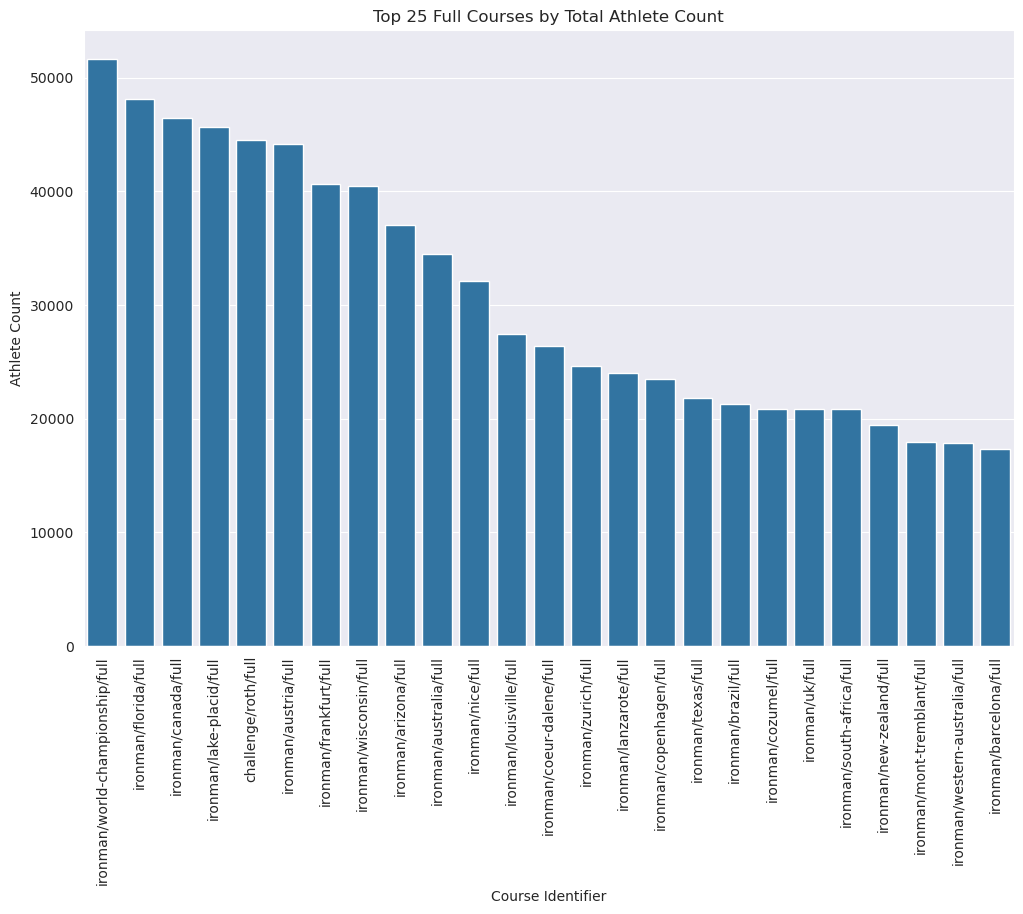

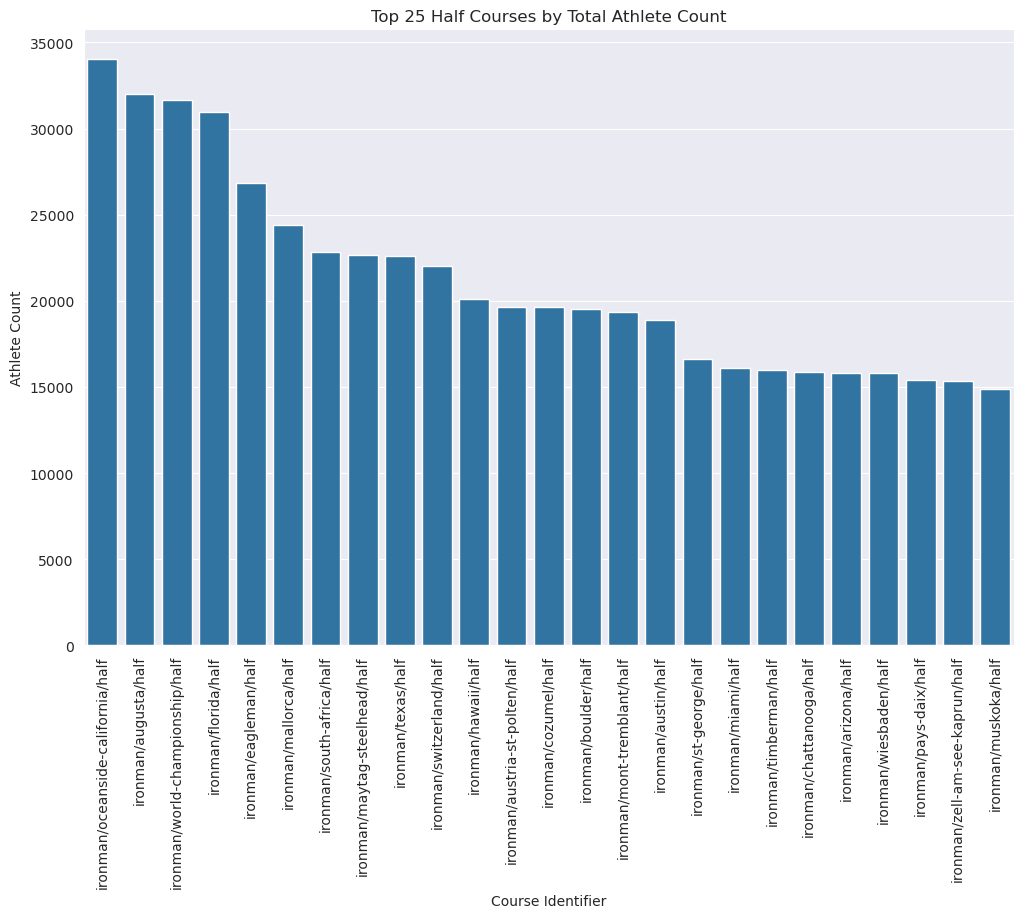

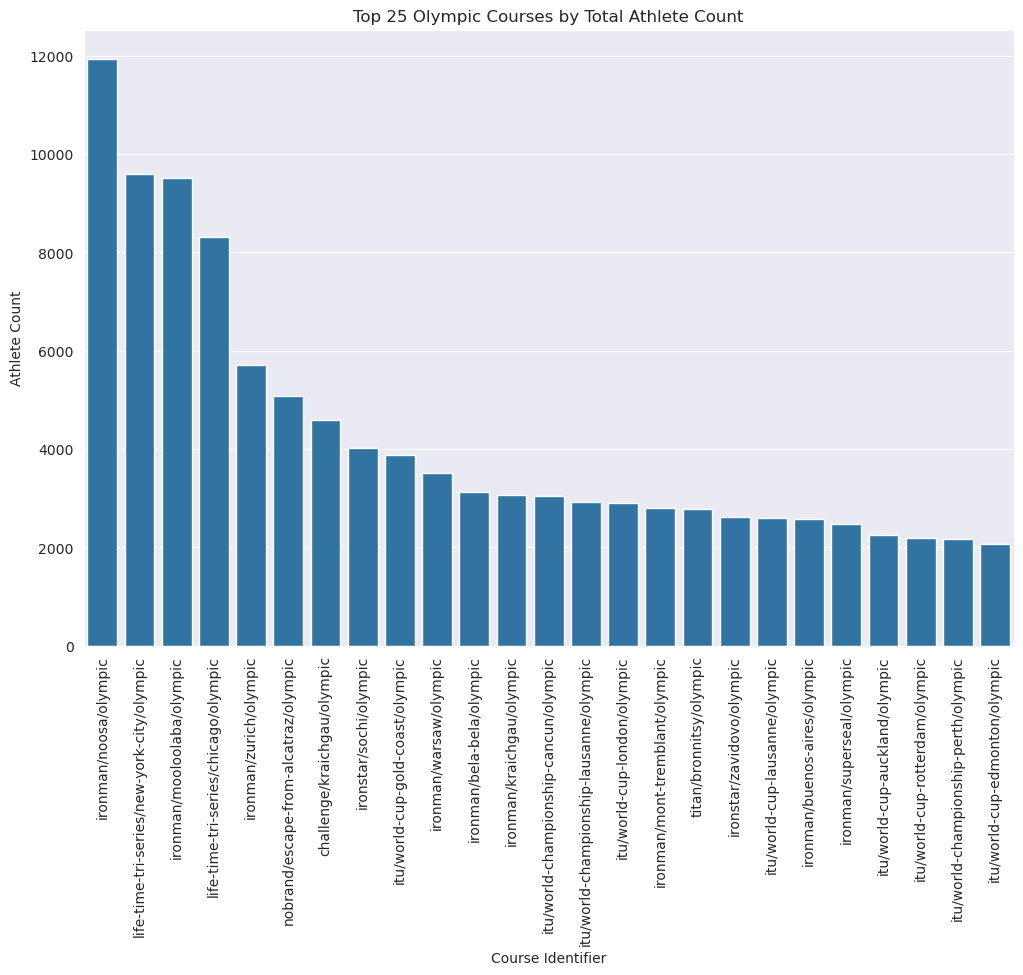

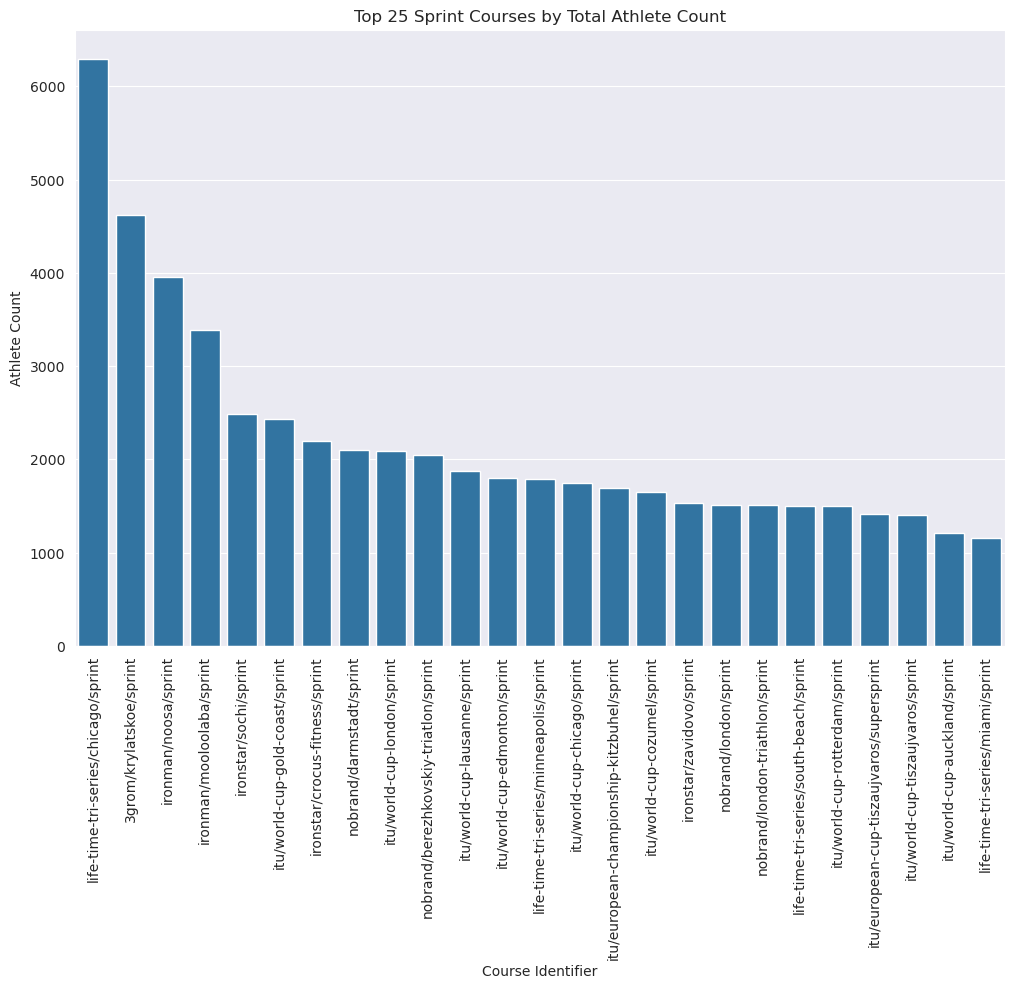

In [29]:
event_types = ['full', 'half', 'olympic', 'sprint']

# Filter the data for each event type and plot the top 25 courses by athlete count
for event_type in event_types:
    # Filter the courses that contain the event type in the course identifier
    event_df = merged_df[merged_df['course_identifier'].str.contains(event_type, case=False, na=False)]
    
    # List unique courses and their counts
    course_counts = event_df['course_identifier'].value_counts()
    
    # Get the top 25 courses by total athlete count
    top_25_courses = course_counts.head(25)
    
    # Plot a histogram for the distribution of the top 25 courses by athlete count for this event type
    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_25_courses.index, y=top_25_courses.values)
    plt.title(f'Top 25 {event_type.capitalize()} Courses by Total Athlete Count')
    plt.xlabel('Course Identifier')
    plt.ylabel('Athlete Count')
    plt.xticks(rotation=90)
    plt.show()

person_name
Triathlete, Taiwan          583
Smith, David                207
Ueda Ai                     199
Yelistratova Yuliya         174
Hosoda Yuichi               170
Sapunov Danylo              167
Polyanskiy Dmitry           160
Frintova Vendula            158
Jones, David                153
Wragg, John                 149
Yamamoto Ryosuke            147
Gaag Dmitriy                146
Smith, Michael              142
Czesnik Maria               142
Takahashi Yuko              137
Niwata Kiyomi               136
Celustka Jan                135
Smith, Scott                134
Grajales Crisanto           134
Sato Yuka                   133
Murua Zubizarreta Ainhoa    130
Kovács Zsófia               130
Garza Heiras Arturo         129
Varga Richard               124
Bravo Elizabeth             122
Name: count, dtype: int64


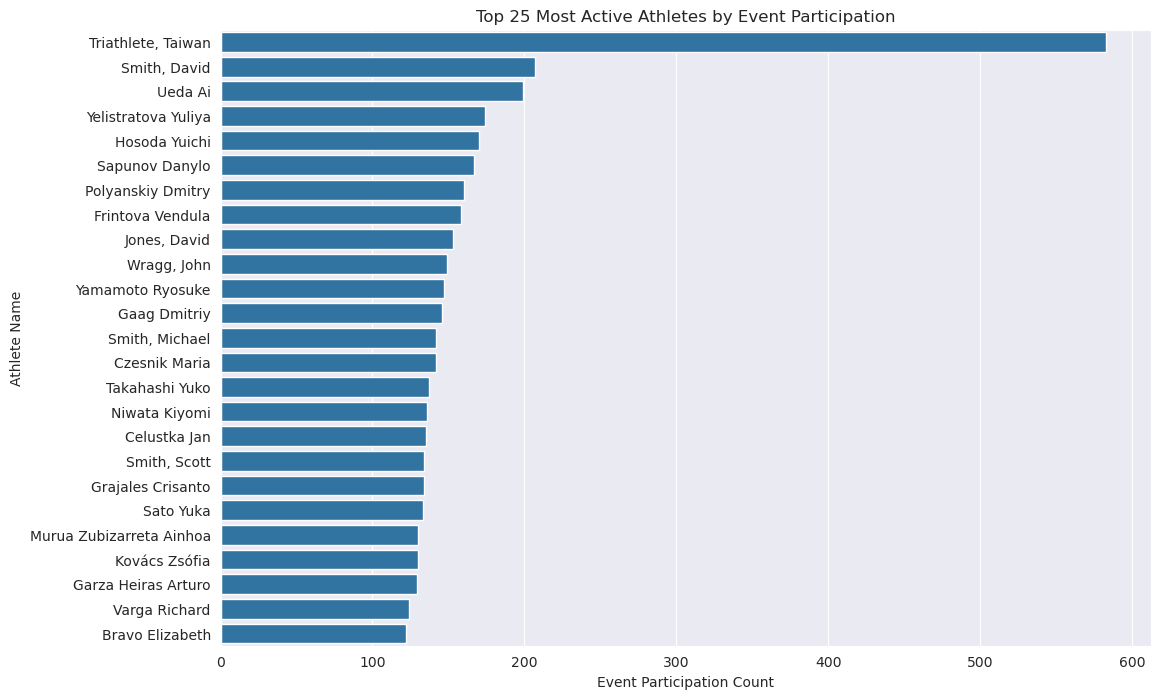

In [30]:
# List athletes and their event participation counts
athlete_counts = merged_df['person_name'].value_counts()

# Get the top 25 most active athletes
top_25_athletes = athlete_counts.head(25)

print(top_25_athletes)

# Plot a histogram for the distribution of the top 25 most active athletes
plt.figure(figsize=(12, 8))
sns.barplot(x=top_25_athletes.values, y=top_25_athletes.index)
plt.title('Top 25 Most Active Athletes by Event Participation')
plt.xlabel('Event Participation Count')
plt.ylabel('Athlete Name')
plt.show()

# Commentary
"Taiwan Triathlete" seems like a category rather than an individual person.  Let's drop those rows. 

In [31]:
merged_df = merged_df[merged_df['person_name'] != "Triathlete, Taiwan"]
# Save the data with percentile scores for further analysis
merged_df.to_csv('data/merged_triathlon_data_with_percentiles.csv', index=False)

person_name
Smith, David                207
Ueda Ai                     199
Yelistratova Yuliya         174
Hosoda Yuichi               170
Sapunov Danylo              167
Polyanskiy Dmitry           160
Frintova Vendula            158
Jones, David                153
Wragg, John                 149
Yamamoto Ryosuke            147
Gaag Dmitriy                146
Czesnik Maria               142
Smith, Michael              142
Takahashi Yuko              137
Niwata Kiyomi               136
Celustka Jan                135
Smith, Scott                134
Grajales Crisanto           134
Sato Yuka                   133
Murua Zubizarreta Ainhoa    130
Kovács Zsófia               130
Garza Heiras Arturo         129
Varga Richard               124
Bravo Elizabeth             122
Williams, Mark              122
Name: count, dtype: int64


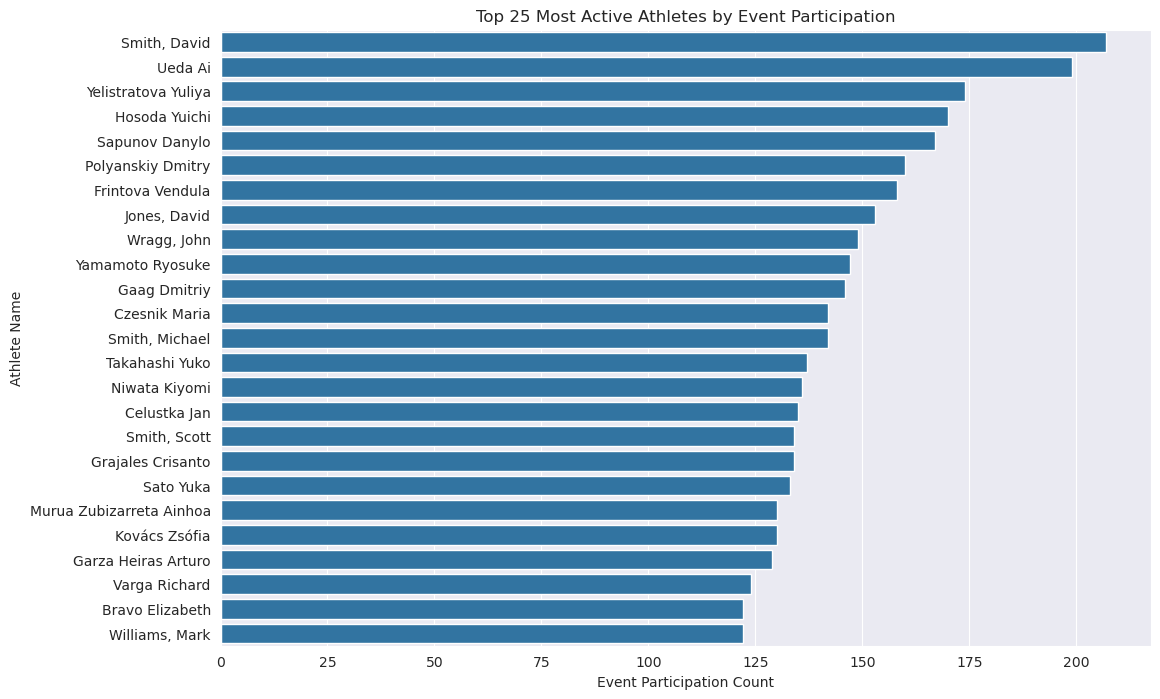

In [32]:
# List athletes and their event participation counts
athlete_counts = merged_df['person_name'].value_counts()

# Get the top 25 most active athletes
top_25_athletes = athlete_counts.head(25)

print(top_25_athletes)

# Plot a histogram for the distribution of the top 25 most active athletes
plt.figure(figsize=(12, 8))
sns.barplot(x=top_25_athletes.values, y=top_25_athletes.index)
plt.title('Top 25 Most Active Athletes by Event Participation')
plt.xlabel('Event Participation Count')
plt.ylabel('Athlete Name')
plt.show()


# Comment
Looking at this data, it's impossible to know whether "David Smith" is a single triathlete or a conglomeration of several athletes with the same name.
However, 200 races is not out of the realm of possibility for a single athlete over a long career.  So, I will choose not to adjust it.

Next, let's see if the data contains any of my personal results!

In [33]:
# Let's see if it has any results for me!

# Specify the athlete's name
athlete_name = "Dole, Todd"  # Replace with the actual name or use input() to prompt

# Filter rows for the given athlete name
athlete_df = merged_df[merged_df['person_name'] == athlete_name].copy()

# Function to convert seconds to hh:mm:ss
def seconds_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

# Convert finish time to hh:mm:ss
athlete_df.loc[:, 'person_event_finish_time_hms'] = athlete_df['person_event_finish_time_text'].apply(seconds_to_hms)

# Select relevant columns including percentiles and reset the index to flatten the DataFrame
athlete_results = athlete_df[['event_link', 'person_name', 'person_event_finish_time_hms', 'percentile']].reset_index(drop=True)

# Print the filtered results
print(athlete_results)


                              event_link person_name  \
0  /rus/result/ironman/florida/full/2007  Dole, Todd   
1  /rus/result/ironman/florida/full/2008  Dole, Todd   
2  /rus/result/ironman/florida/full/2019  Dole, Todd   

  person_event_finish_time_hms  percentile  
0                     14:59:28    0.057269  
1                     15:23:09    0.050147  
2                     14:36:48    0.247678  


# My Results - Commentary
It has a few of my less-than-stellar results.
Let's try perhaps the most winningest triathlete of all time, Chrissie Wellington.  Her percentile scores should be a little better than mine.  (She won every single Ironman
she ever entered.)





# Chrissie Wellington

In [34]:
# Let's see if it has any results for Chrissie Wellington

# Specify the athlete's name
athlete_name = "Wellington, Chrissie"  # Replace with the actual name or use input() to prompt 

# Filter rows for the given athlete name
athlete_df = merged_df[merged_df['person_name'] == athlete_name].copy()
# Convert finish time to hh:mm:ss
athlete_df.loc[:, 'person_event_finish_time_hms'] = athlete_df['person_event_finish_time_text'].apply(seconds_to_hms)

# Select relevant columns including percentiles and reset the index to flatten the DataFrame
athlete_results = athlete_df[['event_link', 'person_name', 'person_event_finish_time_hms', 'percentile']].reset_index(drop=True)

# Print the filtered results
print(athlete_results)

                                          event_link           person_name  \
0               /rus/result/challenge/roth/full/2009  Wellington, Chrissie   
1               /rus/result/challenge/roth/full/2010  Wellington, Chrissie   
2               /rus/result/challenge/roth/full/2011  Wellington, Chrissie   
3              /rus/result/ironman/arizona/full/2010  Wellington, Chrissie   
4            /rus/result/ironman/australia/full/2008  Wellington, Chrissie   
5            /rus/result/ironman/frankfurt/full/2008  Wellington, Chrissie   
6         /rus/result/ironman/south-africa/full/2011  Wellington, Chrissie   
7            /rus/result/ironman/timberman/half/2009  Wellington, Chrissie   
8            /rus/result/ironman/timberman/half/2010  Wellington, Chrissie   
9            /rus/result/ironman/timberman/half/2011  Wellington, Chrissie   
10  /rus/result/ironman/world-championship/full/2007  Wellington, Chrissie   
11  /rus/result/ironman/world-championship/full/2008  Wellington

# Chrissie Wellington Commentary

Sure enough, we have data that looks appropriate for Chrissie Wellington.

Let's look at the 25 highest percentiles and make sure she is on the list


In [35]:
# Calculate the number of events for each athlete
athlete_event_counts = merged_df['person_name'].value_counts()

# Filter athletes with at least ten events
eligible_athletes = athlete_event_counts[athlete_event_counts >= 10].index

# Filter the merged_df to include only eligible athletes
filtered_df = merged_df[merged_df['person_name'].isin(eligible_athletes)]

# Calculate the average adjusted percentile score for each eligible athlete
average_percentiles = filtered_df.groupby('person_name')['percentile'].mean().reset_index()

# Sort by average adjusted percentile score in descending order
sorted_average_percentiles = average_percentiles.sort_values(by='percentile', ascending=False)

# Get the top 25 highest average adjusted percentile athletes
highest_25_athletes = sorted_average_percentiles.head(25)

print(highest_25_athletes)


                person_name  percentile
34038        Vanessa Murray    1.000000
37014         Аликина Мария    1.000000
35308  Wellington, Chrissie    1.000000
4165         Buder, Madonna    1.000000
7462      De Reuck, Colleen    0.999200
16779   Kennedy-Burn, Clive    0.998938
32212        Tabarant, Yves    0.998538
25945         Plat H2 Jetze    0.997917
9125             Eric Engel    0.997539
361           Alcorn, Jenny    0.997361
985           Angus, Damien    0.996647
14682             Hume, Sam    0.995707
20566          Martin Caron    0.995483
31863     Stubleski, Daniel    0.995325
35416      Weste, Griffiths    0.995150
8176        Dommer, Janette    0.994292
4445     Buxhofer, Matthias    0.994155
6716        Cuddeback, Jeff    0.993932
208       Afonenko Anatoliy    0.993750
6743           Cullen, Tony    0.993725
33090          Tom De Bruyn    0.993364
3859          Brooks Donald    0.993246
29558        Schut, Kirsten    0.993208
28652         Sally Taggart    0.992381


# Commentary

Sure enough, Chrissie Wellington is there.  Also, notably, the "Iron Nun" Sister Madonna Buder, who has been uncontested among age 80+ female triathletes. 

# Correlations 

Let's confirm that the correlations within the data are what we'd expect.

First, since the different event types have drastically different time lengths, we would expect finish time to correlate to event type.  Let's go ahead and add an event_type
column and then plot the correlation.

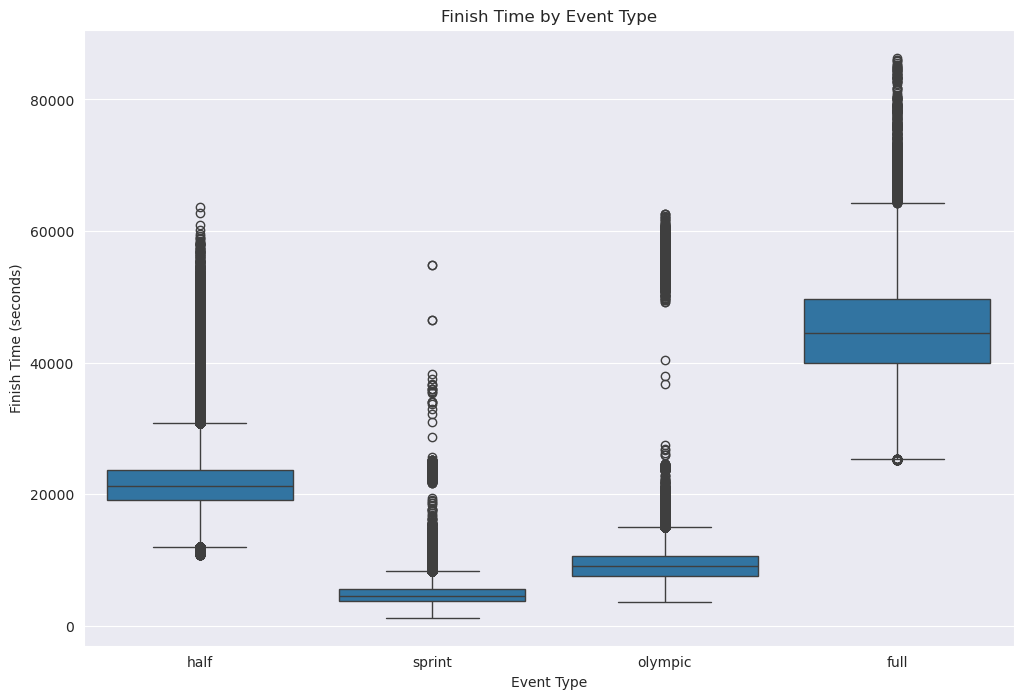

In [36]:
# Plot the distribution of finish times by event type
plt.figure(figsize=(12, 8))
sns.boxplot(x='event_type', y='person_event_finish_time_text', data=merged_df)
plt.title('Finish Time by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Finish Time (seconds)')
plt.show()

/home/tdole/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


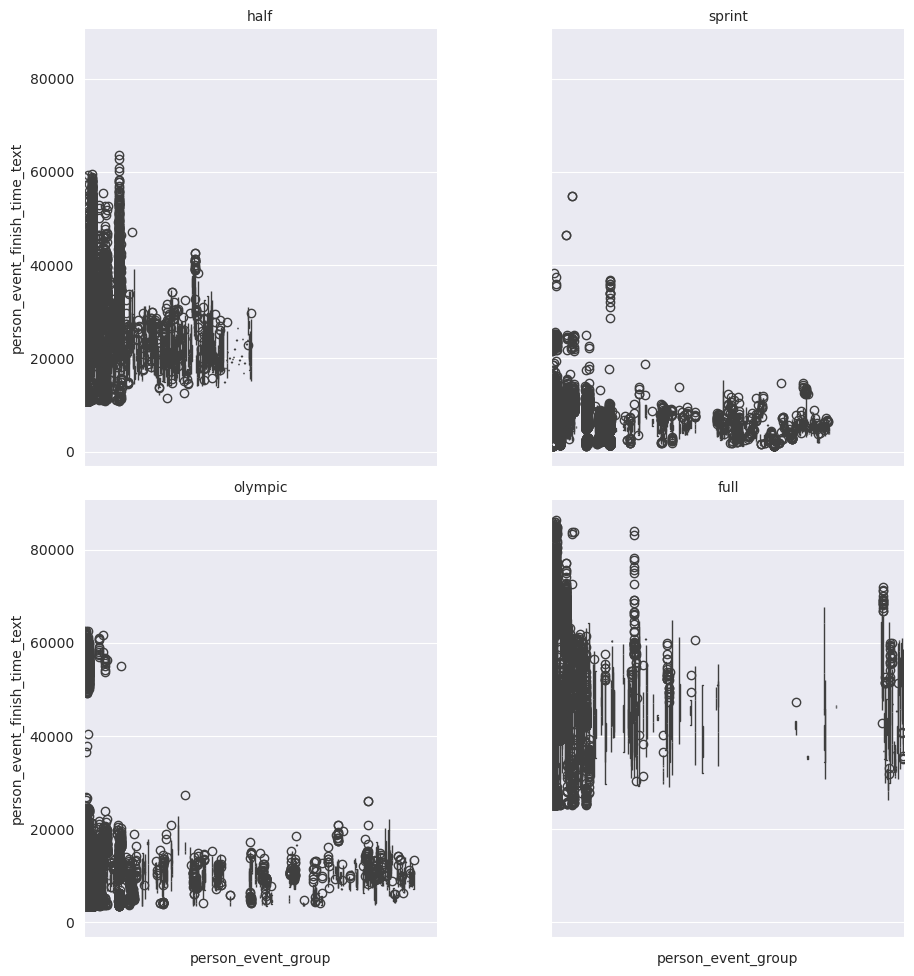

In [37]:
# Plot the distribution of finish times by event group within each event type
g = sns.FacetGrid(merged_df, col="event_type", col_wrap=2, height=5)
g.map(sns.boxplot, "person_event_group", "person_event_finish_time_text")
g.set_xticklabels(rotation=90)
g.set_titles("{col_name}")
plt.show()

# Correlation Matrix

Given our data, it may not show us much that is significant, but let's do it anyway.

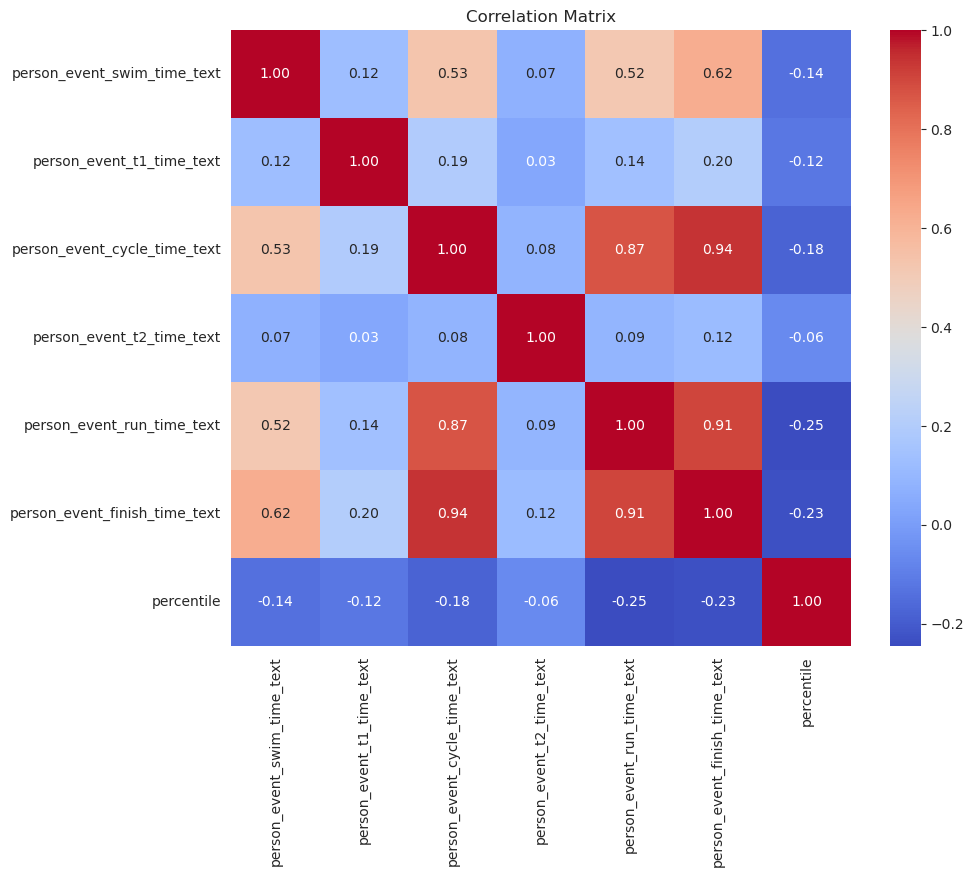

In [38]:
# Select relevant numeric columns for correlation matrix
numeric_columns = ['person_event_swim_time_text', 'person_event_t1_time_text', 'person_event_cycle_time_text',
                   'person_event_t2_time_text', 'person_event_run_time_text', 'person_event_finish_time_text', 
                   'percentile']

# Calculate the correlation matrix
correlation_matrix = merged_df[numeric_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Correlation Matrix Comments

Probably most significant here is that total finish time is most closely correlated wih cycle time and then run time.  That's not surprising, since 
cycling is the longest leg in triathlon (time wise) and running is second. 

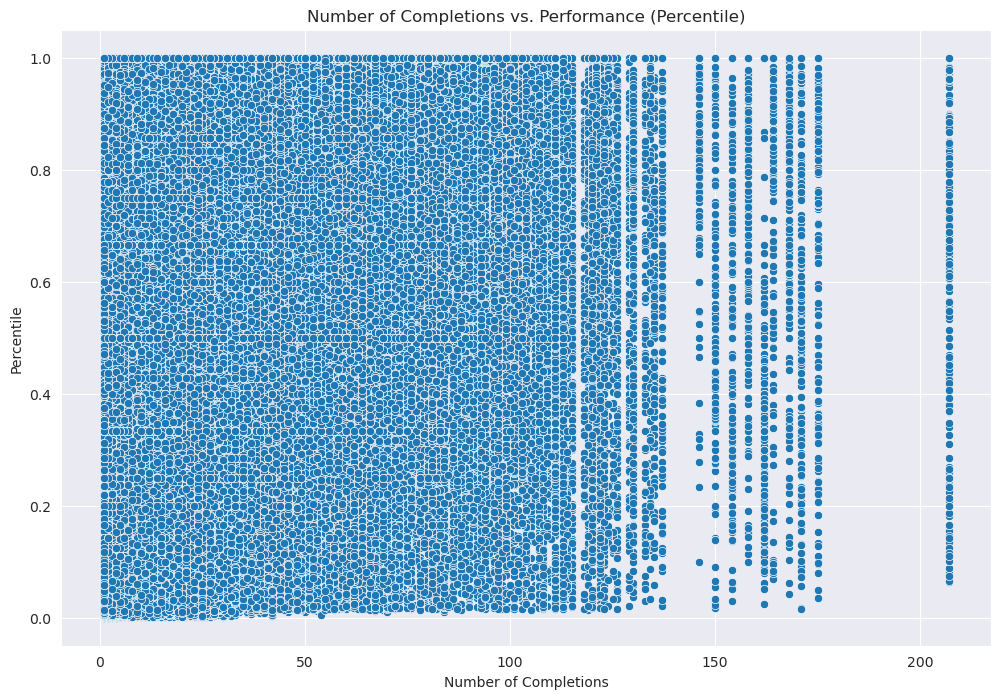

In [39]:
# Create a dataframe for the number of completions
completion_counts = merged_df.groupby(['person_id']).size().reset_index(name='completion_count')

# Merge with the main dataframe
merged_completion_df = pd.merge(merged_df, completion_counts, on='person_id')

# Plot the correlation between number of completions and percentile
plt.figure(figsize=(12, 8))
sns.scatterplot(x='completion_count', y='percentile', data=merged_completion_df)
plt.title('Number of Completions vs. Performance (Percentile)')
plt.xlabel('Number of Completions')
plt.ylabel('Percentile')
plt.show()

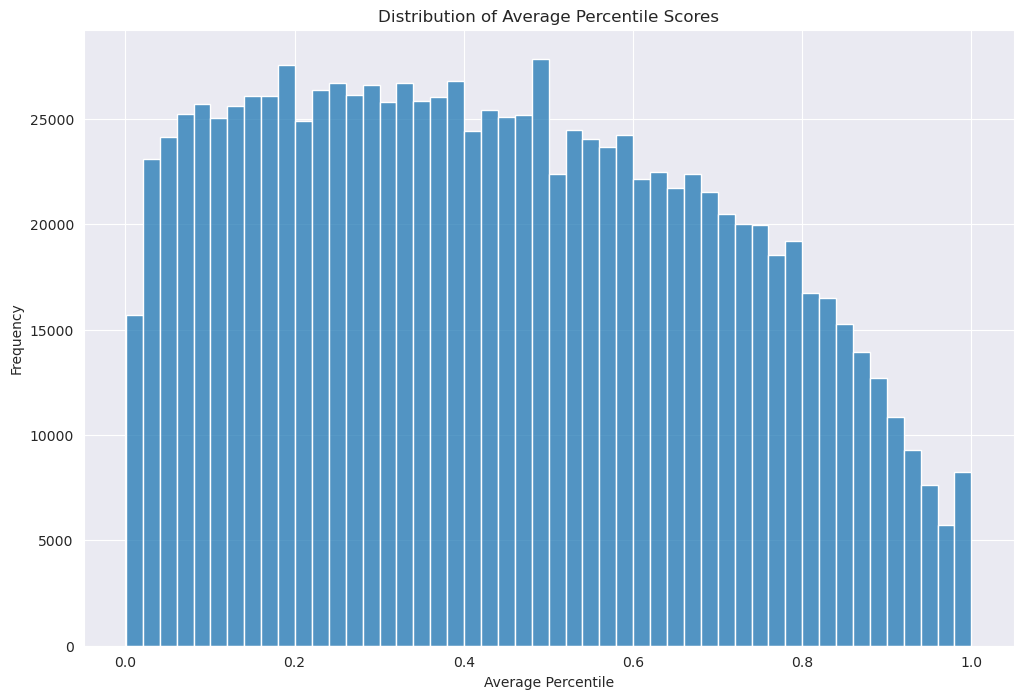

In [40]:
# Calculate the average percentile score for each athlete
average_percentiles = merged_df.groupby('person_id')['percentile'].mean().reset_index()

# Plot the distribution of average percentiles
plt.figure(figsize=(12, 8))
sns.histplot(average_percentiles['percentile'], bins=50)
plt.title('Distribution of Average Percentile Scores')
plt.xlabel('Average Percentile')
plt.ylabel('Frequency')
plt.show()

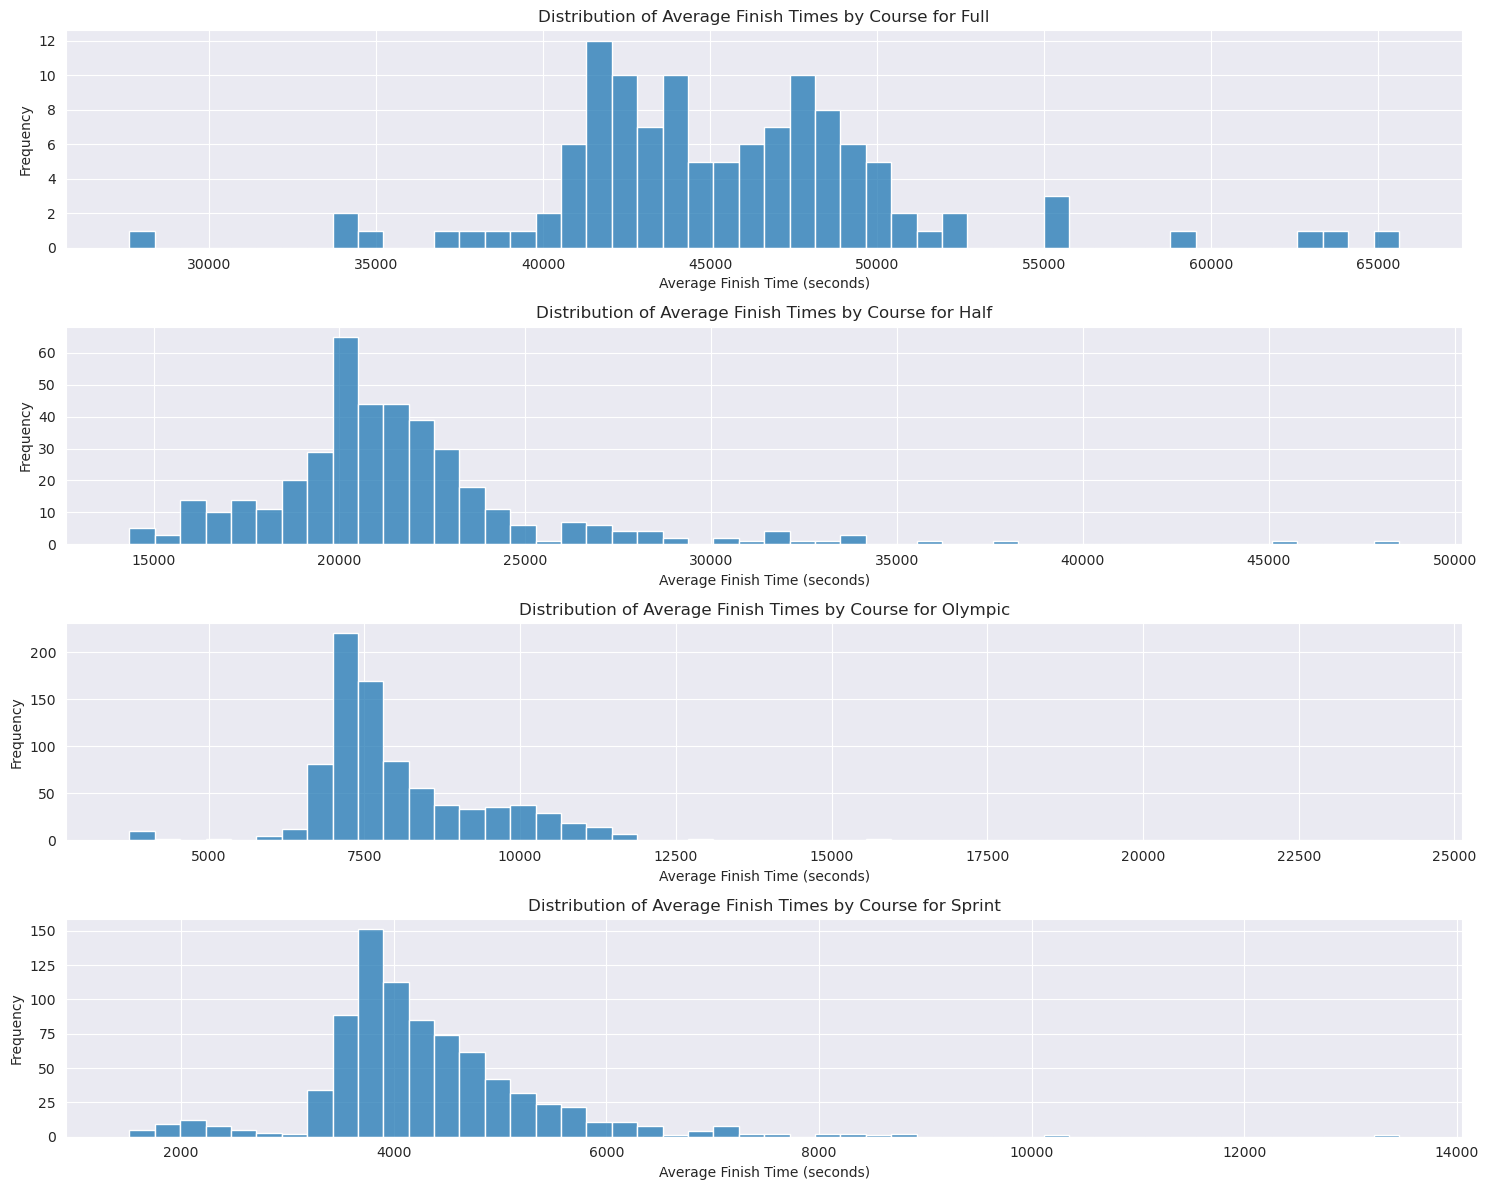

In [41]:
# Calculate the average finish time for each course by event type
average_finish_times_by_type = merged_df.groupby(['event_type', 'course_id'])['person_event_finish_time_text'].mean().reset_index()

# Plot the distribution of average finish times by course and event type
event_types = average_finish_times_by_type['event_type'].unique()

plt.figure(figsize=(15, 12))

for i, event_type in enumerate(event_types):
    plt.subplot(len(event_types), 1, i + 1)
    sns.histplot(average_finish_times_by_type[average_finish_times_by_type['event_type'] == event_type]['person_event_finish_time_text'], bins=50)
    plt.title(f'Distribution of Average Finish Times by Course for {event_type.capitalize()}')
    plt.xlabel('Average Finish Time (seconds)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# EDA IS COMPLETE
    
Time to get to work building our models.

We will begin by creating a table of course id, athlete id and counts

In [42]:
# Group by course_id and person_id and count the number of times each course was completed by each person
completion_counts = merged_df.groupby(['course_id', 'person_id']).size().reset_index(name='completion_count')

# Create the new dataframe with course ID, person ID, and count of times completed
completion_counts_df = completion_counts[completion_counts['completion_count'] > 0]

# Display the new dataframe
print(completion_counts_df)

# Optionally, save the new dataframe to a CSV file
completion_counts_df.to_csv('data/course_person_completion_counts.csv', index=False)

         course_id  person_id  completion_count
0                0          5                 1
1                0        104                 1
2                0        109                 1
3                0        129                 1
4                0        130                 1
...            ...        ...               ...
2351094       2223     854639                 1
2351095       2223     854640                 1
2351096       2223     854641                 1
2351097       2223     854642                 1
2351098       2223     854643                 1

[2351099 rows x 3 columns]


In [43]:
# Display the top 25 highest completion counts
top_25_completions = completion_counts_df.sort_values(by='completion_count', ascending=False).head(25)
print(top_25_completions)

         course_id  person_id  completion_count
275090          47      16744                23
506405          75      23213                20
286474          47     256377                20
1251679        325      16651                19
510395          75     153923                19
1251678        325      16643                19
1252463        325      65068                19
506158          75      22543                19
1252529        325      65134                18
152585          27      22097                18
509903          75     153431                18
740450         156      29990                18
276783          47      43756                18
1252495        325      65100                18
281866          47     125196                18
1252964        325      65569                18
153527          27      52318                18
291196          47     463433                17
282311          47     125641                17
60866            8     105185           

# Model Building

At this point I attempted several different approaches to building a collaborative model. 
Due to the size of the data set, my first several attempts were unsuccessful.

I settled on using Surprise SVD Collaborative Recommender

# Load the data and prepare it for model

In [44]:
# Load the completion counts data
completion_counts_df = pd.read_csv('data/course_person_completion_counts.csv')

# Ensure the data contains only relevant columns
data = completion_counts_df[['person_id', 'course_id', 'completion_count']]

# Define a reader to parse the dataframe
reader = Reader(rating_scale=(1, data['completion_count'].max()))

# Load the data from the dataframe
dataset = Dataset.load_from_df(data, reader)
print(dataset)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(dataset, test_size=0.05, random_state=42)


# Build the model and fit the data

In [45]:
# Use the SVD algorithm
algo = SVD()

# Train the algorithm on the trainset
algo.fit(trainset)

# Let's test the data and see how it works

In [46]:
# Function to recommend courses for a given user
def recommend_courses(user_id, algo, trainset, n=5):
    # Get a list of all course IDs
    all_course_ids = trainset.all_items()
    all_course_ids = [trainset.to_raw_iid(iid) for iid in all_course_ids]
    
    # Predict ratings for all courses not yet rated by the user
    user_course_ids = [iid for (iid, _) in trainset.ur[trainset.to_inner_uid(user_id)]]
    recommendations = []
    
    for course_id in all_course_ids:
        if course_id not in user_course_ids:
            est = algo.predict(user_id, course_id).est
            recommendations.append((course_id, est))
    
    # Sort recommendations by estimated rating
    recommendations.sort(key=lambda x: x[1], reverse=True)
    
    # Return the top N recommendations
    return recommendations[:n]

# Example: Recommend courses for a specific user (replace 'specific_user_id' with an actual user ID)
#specific_user_id = str(completion_counts_df['person_id'].iloc[0])  # Ensure the ID is a string
#recommendations = recommend_courses(specific_user_id, algo, trainset, n=5)
#print(f"Recommended courses for user {specific_user_id}: {recommendations}")

# Get a valid user ID from the training set
valid_user_id = trainset.to_raw_uid(0)

# Example: Recommend courses for a specific user
recommendations = recommend_courses(valid_user_id, algo, trainset, n=5)
print(f"Recommended courses for user {valid_user_id}: {recommendations}")

RMSE: 0.7057
Recommended courses for user 900349: [(902, 3.0010493402417224), (323, 2.9807765799483925), (582, 2.7793198543849775), (427, 2.708929517694417), (544, 2.702450387439329)]


# Check the RMSE

In [47]:
# Evaluate the algorithm on the testset
predictions = algo.test(testset)

# Compute and print RMSE
accuracy.rmse(predictions)


RMSE: 0.7057


0.7056567023684635

# Let's see if we can improve it with hyperparameter grid search

In [48]:
# Define the parameter grid
param_grid = {
    'n_factors': [50, 100, 150],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.2]
}

# Use GridSearchCV to find the best hyperparameters
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose=2)

# Perform the grid search on the entire dataset
gs.fit(dataset)

# Output the best score and the best parameters
print(f"Best RMSE score: {gs.best_score['rmse']}")
print(f"Best parameters: {gs.best_params['rmse']}")



[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 10.8min


Best RMSE score: 0.7166193646940187
Best parameters: {'n_factors': 150, 'lr_all': 0.005, 'reg_all': 0.1}


# Fit the data with the best parametes for further testing

In [49]:
# Get the best model from grid search
best_algo = gs.best_estimator['rmse']

# Train the best algorithm on the trainset
best_algo.fit(trainset)

# Evaluate the best algorithm on the testset
best_predictions = best_algo.test(testset)


RMSE: 0.7063


0.7063378320972956

# Let's see it in action.  Recommend some courses for me!

In [50]:
course_id_to_identifier = {v: k for k, v in course_id_map.items()}

def recommend_courses_improved(user_id, algo, trainset, course_id_to_identifier, n=5):

    # Check if the user exists in the trainset
    if trainset.knows_user(user_id):
        inner_uid = trainset.to_inner_uid(user_id)
        known_user = True
    else:
        print(f"User ID {user_id} not found in training data. Providing fallback recommendations.")
        known_user = False

    # Get all course IDs
    all_course_ids = [trainset.to_raw_iid(iid) for iid in trainset.all_items()]
    user_course_ids = [trainset.to_raw_iid(iid) for (iid, _) in trainset.ur[inner_uid]] if known_user else []
    #print(user_course_ids)

    recommendations = []
    if known_user:
        max=0
        bestcourse=0
        for course_id in all_course_ids:
            if course_id not in user_course_ids:
                est = algo.predict(user_id, course_id).est
                if est > max:
                    bestcourse=course_id
                    max = est
                recommendations.append((course_id, est))
           # else:
                #est = algo.predict(user_id, course_id).est
                #print(f"Known Course: {course_id} -> {est}")
        #print(f"{bestcourse}: {max}")
    else:
        # Fallback: Recommend popular courses or courses with highest overall scores
        for course_id in all_course_ids:
            est = algo.predict(user_id, course_id).est
            recommendations.append((course_id, est))
    
    recommendations.sort(key=lambda x: x[1], reverse=True)
    recommendations = [(course_id_to_identifier[int(course_id)], est) for course_id, est in recommendations[:n]]

    return recommendations

# Convert person_id to string and verify user presence
print("Course recommendations for Todd Dole:")

# Get recommendations for the specific user
recommendations = recommend_courses_improved(726508, best_algo, trainset, course_id_to_identifier, n=100)
print(f"Recommended courses based on performance for user 726508: {recommendations}")


Course recommendations for Todd Dole:
Recommended courses based on performance for user 726508: [('itu/finals-singapore-powered-by-zwift-arena-s-singapore-powered-by-zwift/supersprint', 3.0589763636526577), ('itu/junior-cup-tiszaujvaros-europe-junior-tiszaujvaros/supersprint', 2.81588976853571), ('itu/national-championship-russian-federation/olympic', 2.797279508168685), ('itu/national-championship-japan/olympic', 2.742338950419634), ('nobrand/dubnenskiy-triatlon-nikolov-perevoz/olympic', 2.7370552326104516), ('itu/junior-cup-caorle-europe-junior-caorle/sprint', 2.730633358460877), ('itu/junior-championship-olsztyn-europe-olsztyn/supersprint', 2.637001978822946), ('itu/series-london-powered-by-zwift-arena-london-powered-by-zwift/supersprint', 2.6307482608613353), ('itu/national-championship-china/olympic', 2.6278242406241628), ('itu/youth-championship-festival-alanya-europe-alanya/sprint', 2.611884946279524), ('itu/national-championship-germany/sprint', 2.580609281484176), ('itu/nation

# Let's do some wrap up for part 2

Saving the course_id_to_identifier dict

In [51]:
# Convert the dictionary to a DataFrame
course_id_to_identifier_df = pd.DataFrame(list(course_id_to_identifier.items()), columns=['course_id', 'course_identifier'])

# Save the DataFrame to a CSV file
course_id_to_identifier_df.to_csv('data/course_id_to_identifier.csv', index=False)

# Analysis

After completing the first model, the results seem to favor ITU super sprint championship races for most users.
In many cases these are super sprint races, which is an unusual format that has each racer race the same short course multiple times over a weekend or week.
In some cases, it appears this bumps up the participation numbers by counting each racer as completing the event multiple times.

RMSE may not be the best measure for this ether, and it was disappointing that gridsearchcv did not improve our RMSE at all.

We will make adjustments on the second module.